# Importing Libraries and Dataset

In [1]:
# Import packages
import pandas as pd 
import numpy as np


import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("/kaggle/input/salifort-dataset/HR_Sailfort_dataset.csv")

data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

# Initial Data Exploration and Cleaning

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
data.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [5]:
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
data = data.rename(columns={'Work_accident': 'accidents',
                          'average_montly_hours': 'avg_month_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department',
                          'satisfavtion_level':'satisfaction',
                          'left':'churn',
                          })
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'avg_month_hours', 'tenure', 'accidents', 'churn',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [7]:
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
avg_month_hours          0
tenure                   0
accidents                0
churn                    0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [8]:
data = data.drop_duplicates(keep='first')

data.head()

satisfaction_level  last_evaluation  number_project  avg_month_hours  \
0                0.38             0.53               2              157   
1                0.80             0.86               5              262   
2                0.11             0.88               7              272   
3                0.72             0.87               5              223   
4                0.37             0.52               2              159   

   tenure  accidents  churn  promotion_last_5years department  salary  
0       3          0      1                      0      sales     low  
1       6          0      1                      0      sales  medium  
2       4          0      1                      0      sales  medium  
3       5          0      1                      0      sales     low  
4       3          0      1                      0      sales     low

<Axes: xlabel='tenure'>

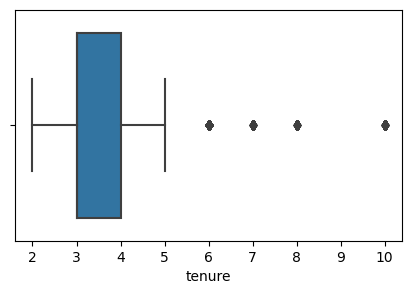

In [9]:
plt.figure(figsize=(5,3))
sns.boxplot(x=data['tenure'])

In [10]:
percentile_25 = data['tenure'].quantile(0.25)
percentile_75 = data['tenure'].quantile(0.75)


iqr = percentile_75 - percentile_25

upper_limit = percentile_75 + 1.5 * iqr
lower_limit = percentile_25 - 1.5 * iqr

print(" upper limit", upper_limit)
print(" lower limit", lower_limit)

outliers = data[(data['tenure']>upper_limit) | (data['tenure']< lower_limit)]

print('the number of outliers in tenure are',len(outliers))

 upper limit 5.5
 lower limit 1.5
the number of outliers in tenure are 824


In [11]:
clean_data = data[(data['tenure'] >= lower_limit) & (data['tenure'] <= upper_limit)]

# Data Exploration Continued

In [12]:
print(clean_data['churn'].replace({0:'stayed',1:'left'}).value_counts())
print('\n')
print(round(clean_data['churn'].replace({0:'stayed',1:'left'}).value_counts(normalize=True)*100))

churn
stayed    9285
left      1882
Name: count, dtype: int64


churn
stayed    83.0
left      17.0
Name: proportion, dtype: float64


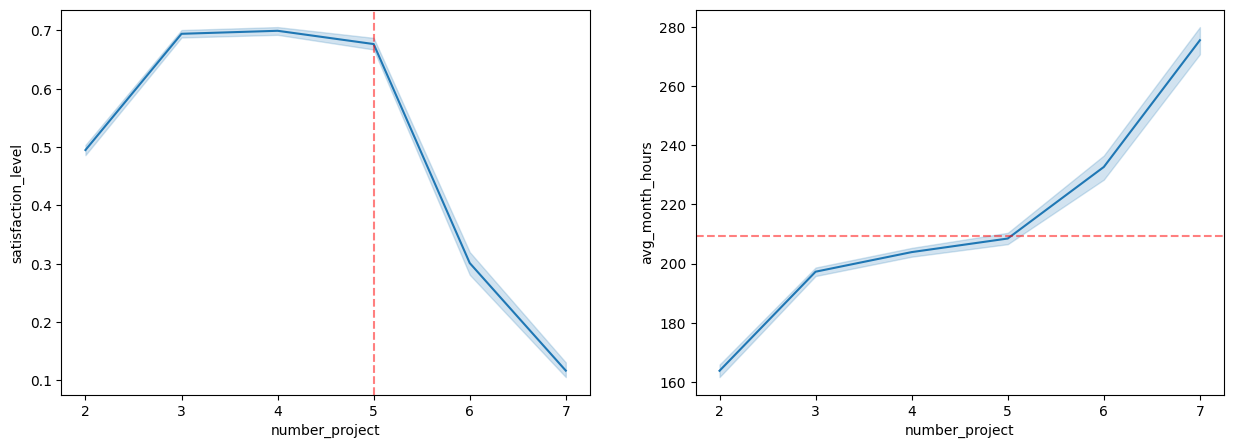

In [13]:
fig, axis = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(x=clean_data['number_project'],y=clean_data['satisfaction_level'],ax=axis[0])
sns.lineplot(x=clean_data['number_project'],y=clean_data['avg_month_hours'],ax=axis[1]) 
axis[0].axvline(x=5, color='red', linestyle='--', alpha=0.5)
axis[1].axhline(y=209.5,color='red',linestyle='--',alpha=.5)
plt.show()

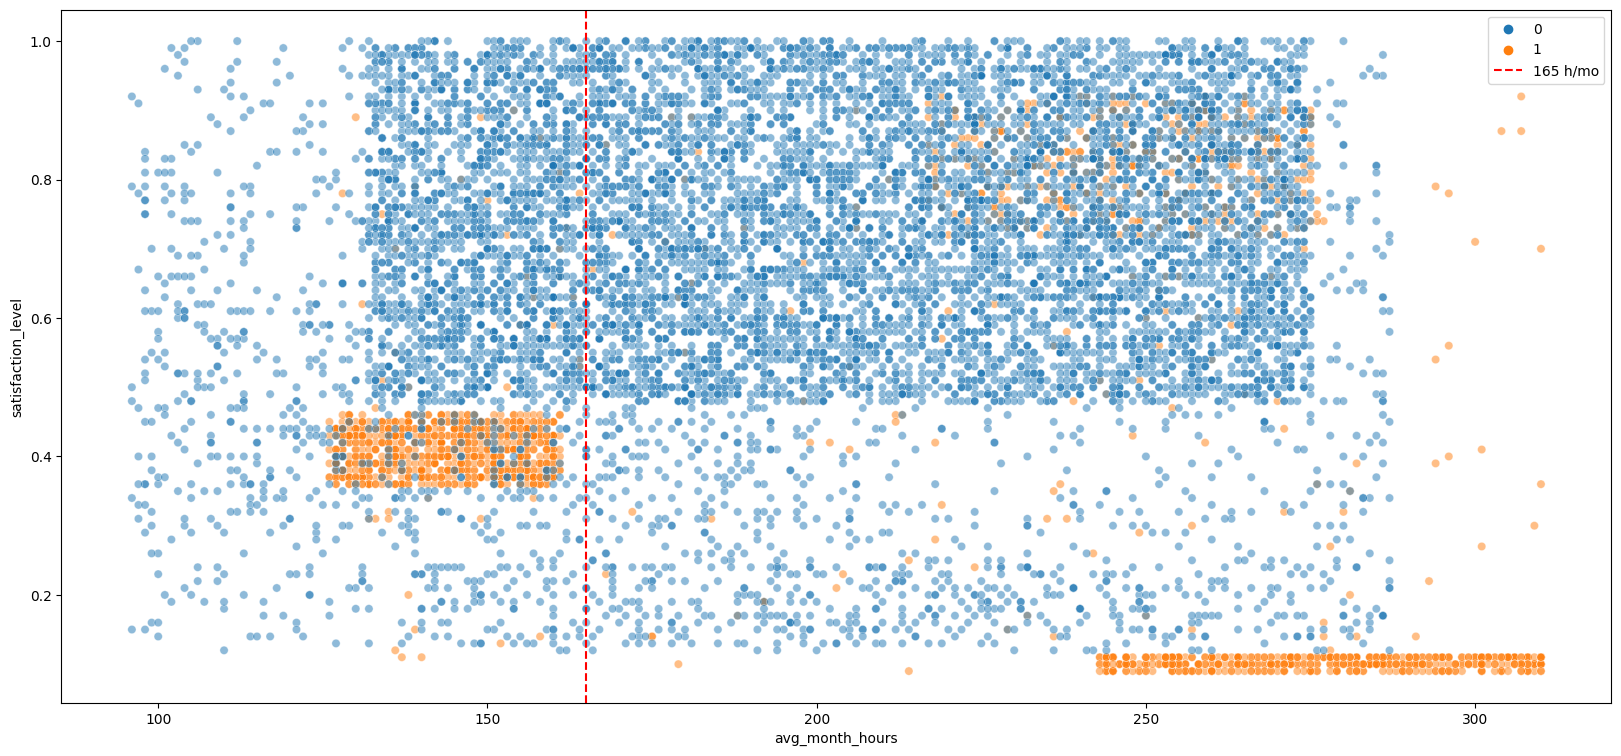

In [14]:
plt.figure(figsize=(20,9))
sns.scatterplot(x=clean_data['avg_month_hours'],y=clean_data['satisfaction_level'],hue=clean_data['churn'],alpha=.5)
plt.axvline(x=165,color='red',ls='--',label='165 h/mo')
plt.legend()

<Axes: xlabel='tenure', ylabel='Count'>

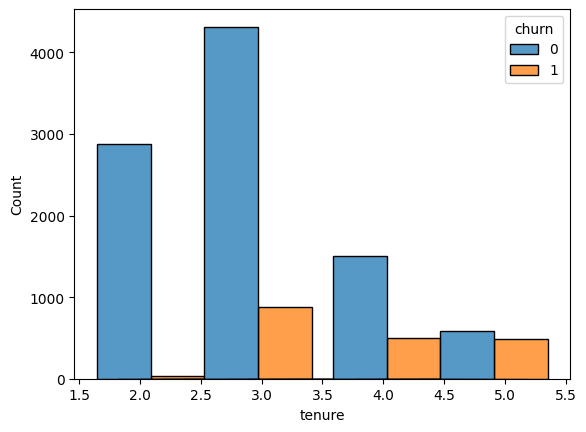

In [15]:
sns.histplot(x=clean_data['tenure'],hue=clean_data['churn'],multiple='dodge',shrink=5)

<Axes: xlabel='satisfaction_level', ylabel='tenure'>

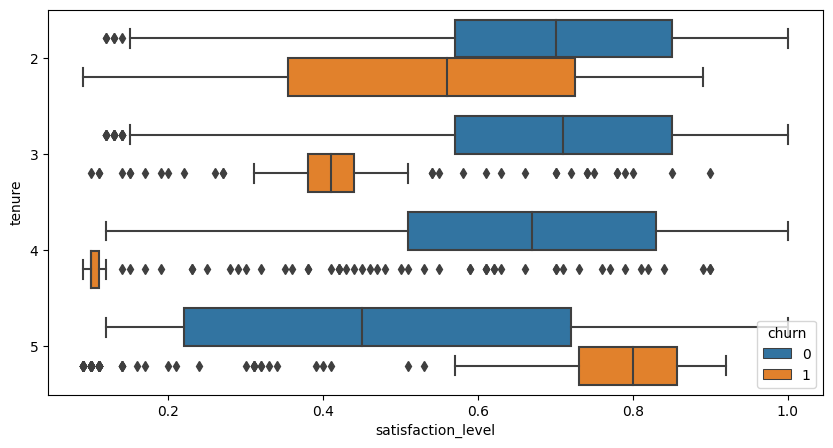

In [16]:
plt.figure(figsize=(10,5))
sns.boxplot(x=clean_data['satisfaction_level'],y=clean_data['tenure'],hue=clean_data['churn'],orient='h')

<Axes: xlabel='tenure', ylabel='satisfaction_level'>

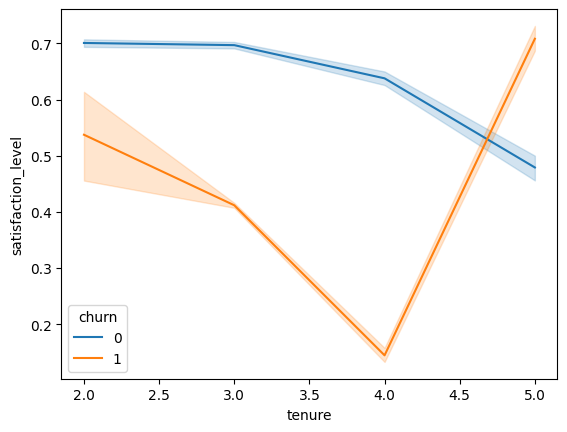

In [17]:
sns.lineplot(x=clean_data['tenure'],y=clean_data['satisfaction_level'],hue=clean_data['churn'])

# Defining Functions

In [18]:
def make_results(model_name=None, model_object=None, trained_model=None, test_data=None, model_prediction=None, scores=None):
    """
    Generates a summary table or prints scores based on model performance metrics.

    Args:
        model_name (str): Name of the model being evaluated.
        model_object (object): The model object, particularly useful for models that have undergone hyperparameter tuning.
        trained_model (bool): Indicates whether the model has been trained or not.
        test_data (array-like): Test data used to evaluate the model.
        model_prediction (array-like): Predictions made by the model on the test data.
        scores (bool): Indicates whether to print individual scores or return a table.

    Returns:
        pd.DataFrame or None: Summary table with model name and corresponding performance metrics, or None if scores are printed.

    """
    if trained_model:
        # Calculate performance metrics based on model predictions
        # and return a summary table
            # Generate summary table
                table = pd.DataFrame({
                       'Model Name': [model_name],
                       'Accuracy': [round(metrics.accuracy_score(test_data, model_prediction) * 100,2)],
                       'Recall': [round(metrics.recall_score(test_data, model_prediction) * 100,2)],
                       'Precision': [round(metrics.precision_score(test_data, model_prediction) * 100,2)],
                       'F1': [round(metrics.f1_score(test_data, model_prediction) * 100,2)],
                       'Roc_Auc': [round(metrics.roc_auc_score(y_true=test_data, y_score=model_prediction) * 100,2)]
                        })
                return table
    elif scores:
            # Print individual scores
            print(f"Accuracy score of {model_name}: {round(metrics.accuracy_score(test_data, model_prediction) * 100,2)}")
            print(f"Recall score of {model_name}: {round(metrics.recall_score(test_data, model_prediction) * 100,2)}")
            print(f"Precision score of {model_name}: {round(metrics.precision_score(test_data, model_prediction) * 100,2)}")
            print(f"F1 Score score of {model_name}: {round(metrics.f1_score(test_data, model_prediction) * 100,2)}")
            print(f"ROC AUC score of {model_name}: {round(metrics.roc_auc_score(test_data,model_prediction) * 100,2)}")
    else:
        # Extract results from cross-validation to identify the best performing model
        grid_results = pd.DataFrame(model_object.cv_results_)
        best_estimators = grid_results.iloc[grid_results['mean_test_f1_macro'].idxmax(), :]
        # Compute metrics based on the best performing model
        accuracy = round(best_estimators.mean_test_accuracy * 100,2)
        recall = round(best_estimators.mean_test_recall_macro * 100,2)
        precision = round(best_estimators.mean_test_precision_macro * 100,2)
        f1 = round(best_estimators.mean_test_f1_macro * 100,2)
        roc_auc = round(best_estimators.mean_test_roc_auc * 100,2)
        # Generate summary table
        table = pd.DataFrame({
            'Model Name': [model_name],
            'Accuracy': [accuracy],
            'Recall': [recall],
            'Precision': [precision],
            'F1': [f1],
            'Roc_Auc': [roc_auc]
        })
        return table


In [19]:
def confusion_matrix(test_data=None, model=None, multiple=None, model_2=None, model_3=None, model_4=None, x_tr=None, y_tr=None, actual_data=None,model_pred=None,DataFrame=None|bool,w=None|int,l=None|int,f=None|int):
    if multiple:
        # Plot confusion matrices for multiple models
        models = [model, model_2, model_3, model_4]
        fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(w, l))
        for i, j in enumerate(models):
            # Predictions on test and training data
            model_predict_test = j.predict(test_data)
            model_predict_training = j.predict(x_tr)
            # Plot confusion matrix for test data
            axes[i, 0].set_title(f'Confusion Matrix of model {i} on Test Data',fontsize=f)
            metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(actual_data, model_predict_test),
                                           display_labels=['False', 'True']).plot(ax=axes[i, 0])
            # Plot confusion matrix for training data
            axes[i, 1].set_title(f'Confusion Matrix of model {i} on Training Data',fontsize=f)
            metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_tr, model_predict_training),
                                   display_labels=['False', 'True']).plot(ax=axes[i, 1])
            fig.tight_layout()
    elif DataFrame:
        models = [model, model_2, model_3, model_4]
        table=pd.DataFrame()
        for i,j in enumerate(models):
            model_predict_test = j.predict(test_data)
            model_predict_training = j.predict(x_tr)
            report = metrics.confusion_matrix(y_true=actual_data,y_pred=model_predict_test)
            report_train = metrics.confusion_matrix(y_true=y_tr,y_pred=model_predict_training)
            TN = round(report[0,0]/len(test_data)*100,2)
            TP = round(report[1,1]/len(test_data)*100,2)
            FN = round(report[1,0]/len(test_data)*100,2)
            FP = round(report[0,1]/len(test_data)*100,2)
            TNT=round(report_train[0,0]/len(x_tr)*100,2)
            TPT=round(report_train[1,1]/len(x_tr)*100,2)
            FNT = round(report_train[1,0]/len(x_tr)*100,2)
            FPT = round(report_train[0,1]/len(x_tr)*100,2)

            cm = pd.DataFrame({'Model Name':[f'model {i}'],
            'True Negatives':[TN],
            'True Positives':[TP],
            'False Negatives':[FN],
            'False Positives':[FP],
            'True Negatives Training':[TNT],
            'True Positives Training':[TPT],
            'False Negatives Training':[FNT],
            'False Positives Training':[FPT]})
            table = pd.concat([table,cm],ignore_index=True)
        return table
    else:
        # Plot confusion matrix for single model
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(test_data, model_pred),
                                               display_labels=['False', 'True'])
        disp.plot()


# Model Building

In [20]:
# Encoding the data
encoded = pd.get_dummies(clean_data,drop_first=False)
encoded.head()

satisfaction_level  last_evaluation  number_project  avg_month_hours  \
0                0.38             0.53               2              157   
2                0.11             0.88               7              272   
3                0.72             0.87               5              223   
4                0.37             0.52               2              159   
5                0.41             0.50               2              153   

   tenure  accidents  churn  promotion_last_5years  department_IT  \
0       3          0      1                      0          False   
2       4          0      1                      0          False   
3       5          0      1                      0          False   
4       3          0      1                      0          False   
5       3          0      1                      0          False   

   department_RandD  ...  department_hr  department_management  \
0             False  ...          False                  False   
2             False  ...          False                  False   
3             False  ...          False                  False   
4             False  ...          False                  False   
5             False  ...          False                  False   

   department_marketing  department_product_mng  department_sales  \
0                 False                   False              True   
2                 False                   False              True   
3                 False                   False              True   
4                 False                   False              True   
5                 False                   False              True   

   department_support  department_technical  salary_high  salary_low  \
0               False                 False        False        True   
2               False                 False        False       False   
3               False                 False        False        True   
4               False                 False        False        True   
5               False                 False        False        True   

   salary_medium  
0          False  
2           True  
3          False  
4          False  
5          False  

[5 rows x 21 columns]

In [21]:
# Selecting The Variables
Y = encoded['churn']

X = encoded.copy()
X=X.drop('churn',axis=1)

# Splitting the Train Test Data
x_train, x_test, y_train, y_test = train_test_split(X,Y,stratify=Y,test_size=0.3,random_state=42)

# Machine Learning

- Single Decision Tree
- Hyperparameter Tuned Decision Tree
- Random Forest
- Gradient Boost Random Forest

### Tasks :- 
- First we will build a single Decision Tree
- Second we will conduct Hyperparameter Grid search to find the optimal parameters for our decision tree
- Third we will conduct Grid Search on random forest to find the best parameters
- Lastly we will conduct Gradient Boosting Grid Search with different parameters to find the best Optimal parameters for Boosting

## Single Decision Tree

In [22]:
# Instantiating the Decision Tree
tree1 = DecisionTreeClassifier(random_state=42)

In [23]:
# Fitting the model to Training data
tree1.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [24]:
# Predicting the model on test data
tree1_pred = tree1.predict(x_test)

In [25]:
make_results(trained_model=True,model_name="Single Decision Tree",test_data=y_test,model_prediction=tree1_pred)

Model Name  Accuracy  Recall  Precision    F1  Roc_Auc
0  Single Decision Tree     97.17   91.68      91.52  91.6    94.98

##### We can see that the model performed quite well on the test data

In [26]:
tree1.get_depth()

21

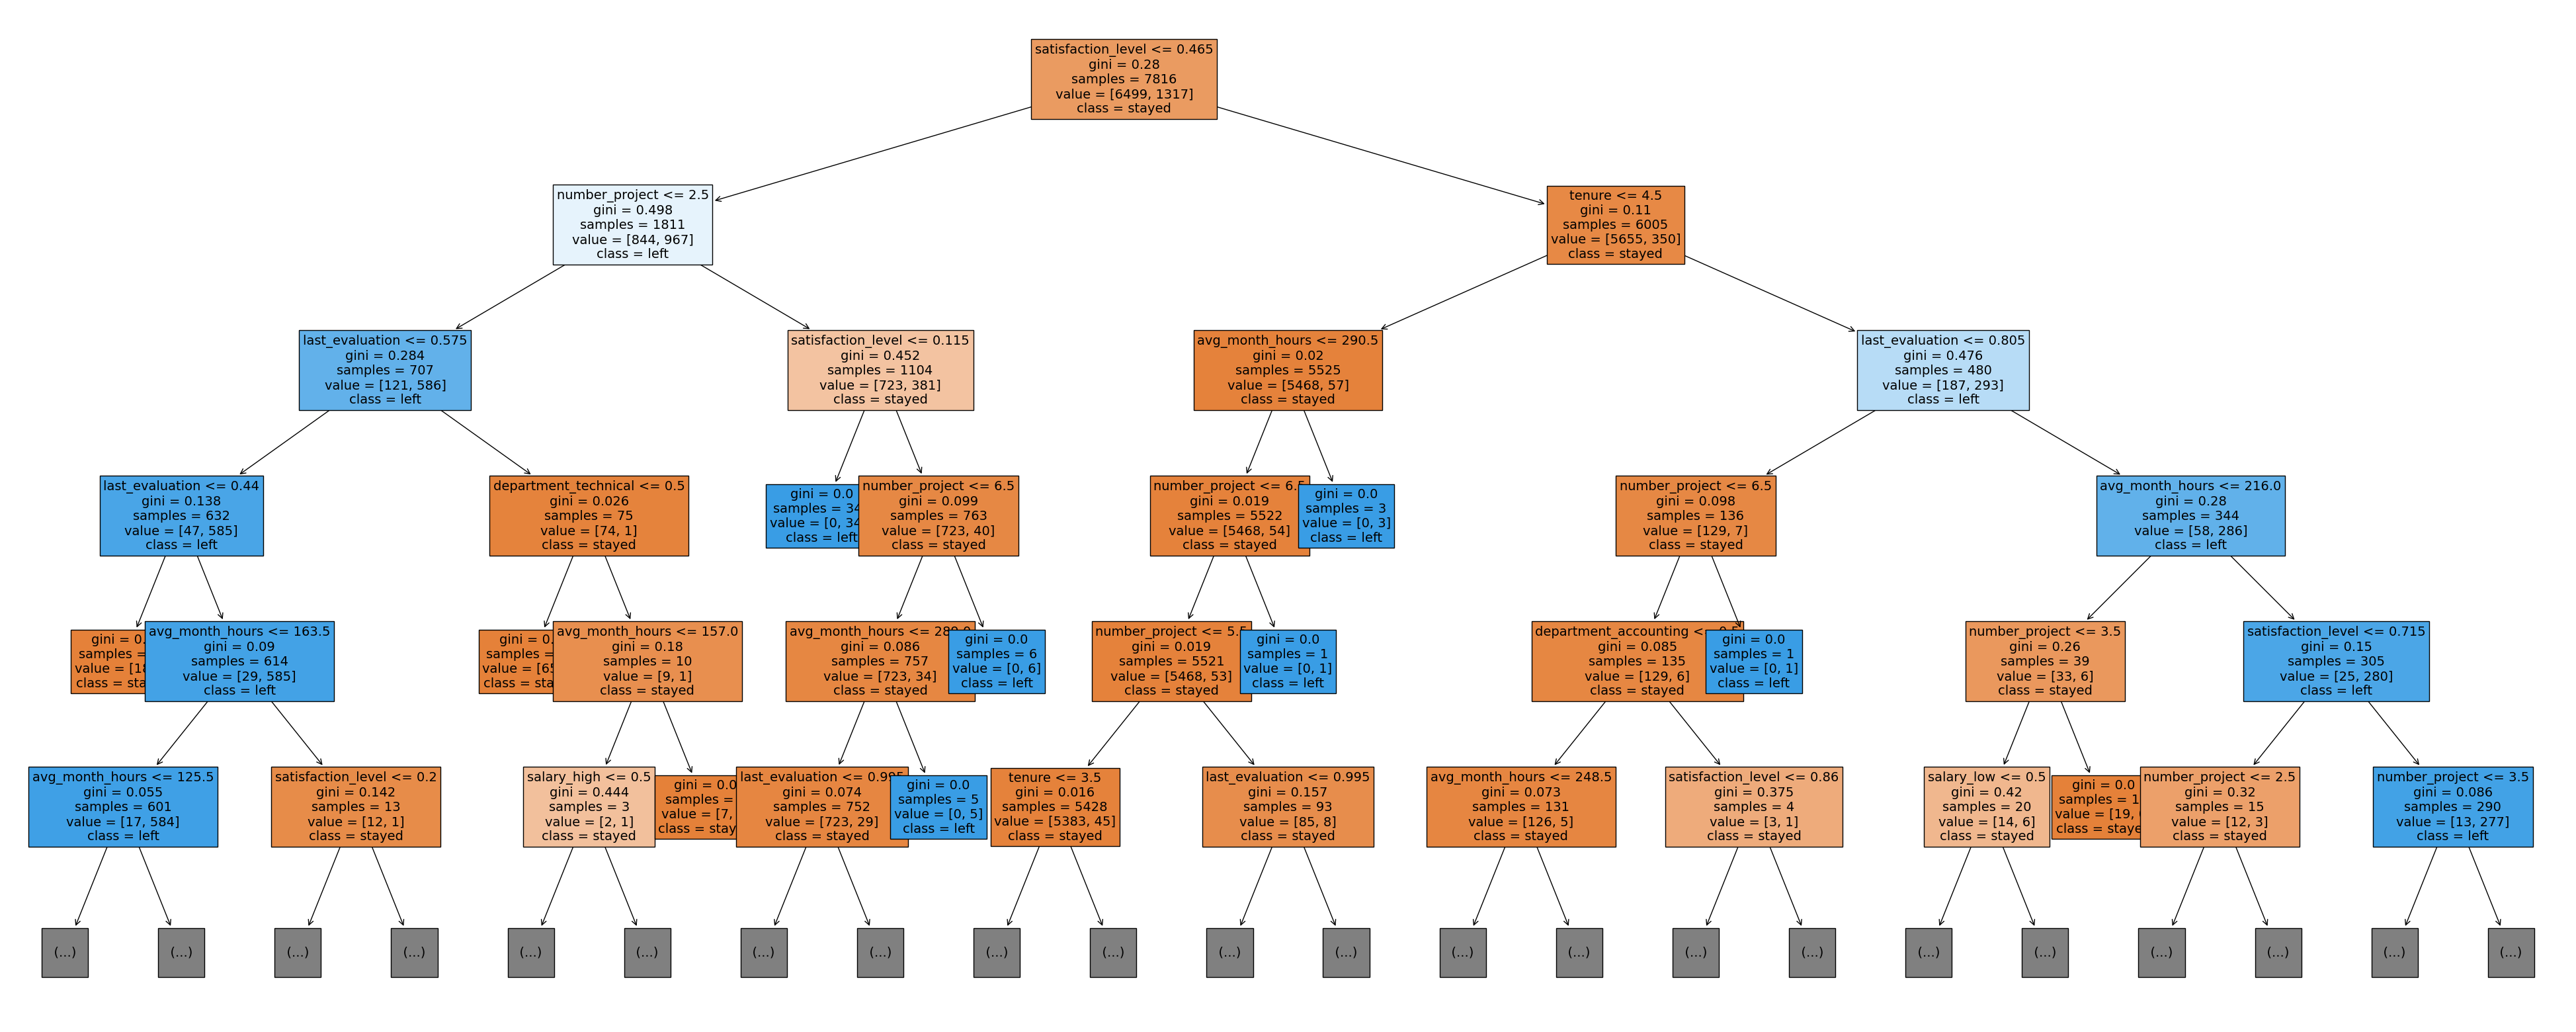

In [27]:
plt.figure(figsize=(50,20))
plot_tree(tree1,feature_names=X.columns,max_depth=5,class_names={0:'stayed', 1:'left'}, filled=True,fontsize=14)
plt.show()

## Hyper Parameter Tuning

We are doing hyperparameters on a Decision Tree to compare it to our normal Decision Tree to find that does the tuned decision tree is better or the normal one

Before tuning our model's settings, we need to pick the measurements we'll use to judge how well it's performing:

#### Recall evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example. 
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.

We're also planning to stop the training early to save time and computer power. This means if our model stops improving, we'll stop training it further to avoid wasting resources.

In [28]:
# GridSearchCV for decision tree hyperparameter tuning with ROC AUC scoring, fitting optimal model to train/test data.

tree_paras = {'max_depth' : [2,4,6,8,10,12,14,16,18,20,None],
              'min_samples_leaf':[2,3,4,5,6,7,8,9,10],
              'criterion':['gini','entropy']
              }
score = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro','roc_auc']

In [29]:
# GridSearchCV for decision tree hyperparameter tuning with specified metrics and cross-validation.

tree1_grid = GridSearchCV(estimator=tree1,
                          param_grid=tree_paras,
                          scoring=score,
                          refit='roc_auc',
                          cv=5,
                          n_jobs=-1,
                          verbose=1)

In [30]:
%%time
tree1_grid.fit(x_train,y_train) # Fitting the model

Fitting 5 folds for each of 198 candidates, totalling 990 fits
CPU times: user 1.18 s, sys: 172 ms, total: 1.35 s
Wall time: 14.4 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                       None],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='roc_auc',
             scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                      'roc_auc'],
             verbose=1)

In [31]:
# Finding the optimal parameters
tree1_grid.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=42)

In [32]:
tree1_grid.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3}

In [33]:
# Fitting optimal decision tree model to data with specified hyperparameters.
optimal_tree = DecisionTreeClassifier(max_depth=4,min_samples_leaf=3,random_state=42)

In [34]:
# Fitting the optimal decision tree
optimal_tree.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=42)

In [35]:
# Predicting the Tree
optimal_tree_pred = optimal_tree.predict(x_test)

In [36]:
make_results(trained_model=True,model_name="Tuned Decision Tree",test_data=y_test,model_prediction=optimal_tree_pred)

Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Tuned Decision Tree     98.12   91.86      96.83  94.28    95.62

##### Again we can see that the tune decision tree performe quite well in terms of `Roc_Auc` scores

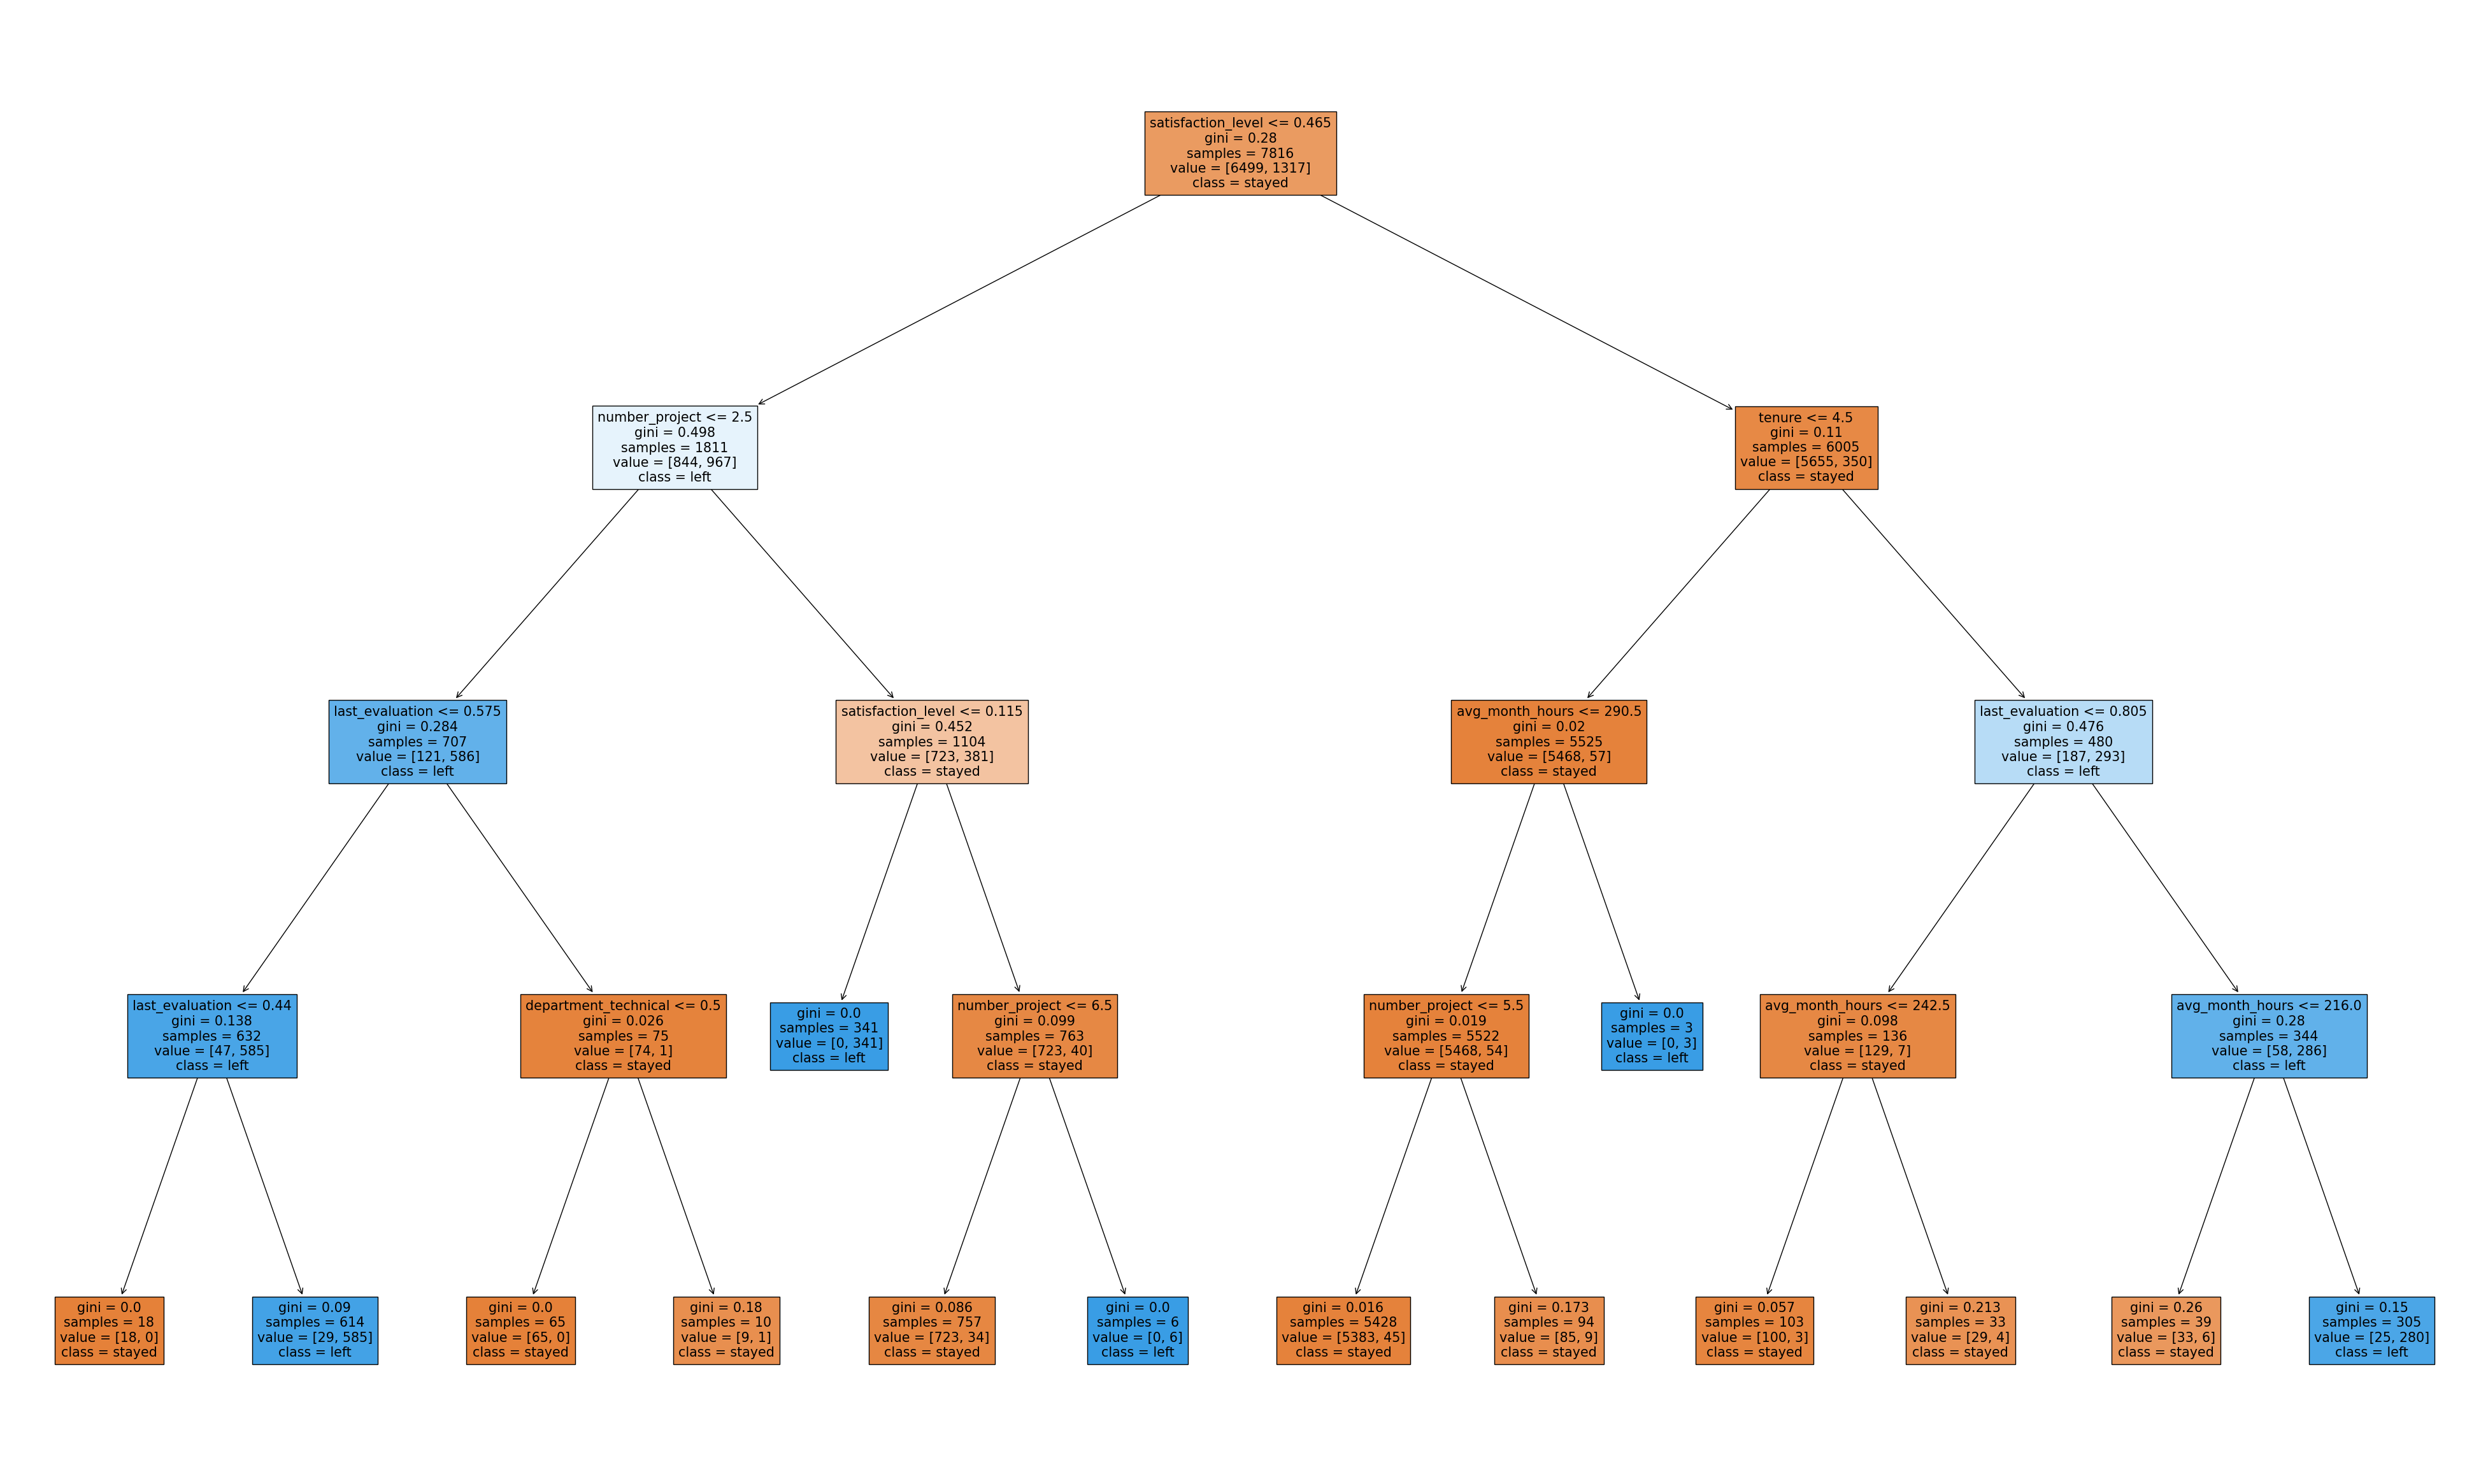

In [37]:
plt.figure(figsize=(50,30))
plot_tree(optimal_tree,feature_names=X.columns,class_names={0:'stayed', 1:'left'}, filled=True)
plt.show()

## Random Forest

In [38]:
# Speifying the Parameters for Grid Search

forest_para = {'max_depth':[5,10,20,30,None],
               'min_samples_leaf':[1,2,3,4,None],
               'min_samples_split':[2,3,4,5,None],
               'max_features':["sqrt"],
               'max_samples':[0.5,0.7,0.8,None],
               'n_estimators':[50,70,100,None]
               }

In [39]:
# Instatiating the Random Forest
forest = RandomForestClassifier(random_state=42)

In [40]:
# GridSearchCV for hyperparameter tuning of the random forest model, and using ROC AUC as the scoring metric for evaluation.

forest_grid = GridSearchCV(estimator=forest,
                           param_grid=forest_para,
                           scoring=score,
                           cv=5,
                           refit='roc_auc',
                           n_jobs=-1,
                           verbose=1)

In [41]:
%%time
forest_grid.fit(x_train,y_train) # Fitting the GridSearchCV object to train data

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
CPU times: user 15.6 s, sys: 1.95 s, total: 17.6 s
Wall time: 10min 54s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, None],
                         'max_features': ['sqrt'],
                         'max_samples': [0.5, 0.7, 0.8, None],
                         'min_samples_leaf': [1, 2, 3, 4, None],
                         'min_samples_split': [2, 3, 4, 5, None],
                         'n_estimators': [50, 70, 100, None]},
             refit='roc_auc',
             scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                      'roc_auc'],
             verbose=1)

In [42]:
# finding the best hyperparameters for the random forest model
forest_grid.best_estimator_

RandomForestClassifier(max_depth=20, max_samples=0.7, min_samples_leaf=3,
                       random_state=42)

In [43]:
# Instantiating the optimal random forest model with predetermined hyperparameters based on the results of GridSearchCV.

optimal_tree_forest = RandomForestClassifier(max_depth=20,
                                             max_samples=0.7,
                                             random_state=42,
                                             min_samples_split=4,
                                             min_samples_leaf=3)

In [44]:
# Fitting the optimal random forest model to the training data to make predictions.
optimal_tree_forest.fit(x_train,y_train)

RandomForestClassifier(max_depth=20, max_samples=0.7, min_samples_leaf=3,
                       min_samples_split=4, random_state=42)

In [45]:
# Making Predictions with the Optimal Model
optimal_tree_forest_pred = optimal_tree_forest.predict(x_test)

In [46]:
make_results(trained_model=True,model_name="Optimal Random Forest",model_prediction=optimal_tree_forest_pred,test_data=y_test)

Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Optimal Random Forest     98.21   90.44      98.84  94.45    95.11

##### The `Random Forest` performed extensively well on the test data and has quite a good `Roc_Auc` score

## Gradent Boosting Model

In [47]:
# Define a dictionary containing the parameters to be tuned for the XGBoost model
gradient_parameters = {
    'max_depth': [8, 10, 20, 30, 40, 50,None],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [3, 5],
    'learning_rate': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'subsample': [0.5, 0.6, 0.7]
}


In [48]:
# Instatiating the mMdel
boost = XGBClassifier(objective='binary:logistic',random_state=42)

In [49]:
# Create a GridSearchCV object for hyperparameter tuning of XGBoost model
boost_grid = GridSearchCV(
    estimator=boost,  # 'boost' is assumed to be the XGBoost classifier object
    param_grid=gradient_parameters,  # Grid of parameters to search over
    scoring=score,  # Scoring metric for evaluation
    cv=5,  # Number of folds for cross-validation
    refit='roc_auc',  # Refit the best model with ROC AUC score
    n_jobs=-1,  # Use all available CPU cores for parallel computation
    verbose=1  # Verbosity level: 2 for detailed output
)

In [50]:
%%time
boost_grid.fit(x_train, y_train)  # Fit the GridSearchCV object to the training data and measure the time taken for tuning

Fitting 5 folds for each of 1134 candidates, totalling 5670 fits
CPU times: user 20.7 s, sys: 2.63 s, total: 23.3 s
Wall time: 12min 3s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7],
                         'learning_rate': [0.5, 0.6, 0.7],
                         'max_depth': [8, 10, 20, 30, 40, 50, None],
                         'min_child_weight': [3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.6, 0.7]},
             refit='roc_auc',
             scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                      'roc_auc'],
             verbose=1)

In [51]:
# Retrieve the best estimator from the hyperparameter tuning process
boost_grid.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [52]:
boost_grid.best_score_*100

97.91289357579082

In [53]:
boost_grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.5,
 'max_depth': 8,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.7}

In [54]:
# Instantiate an XGBoost classifier with the optimal hyperparameters
optimal_boost_forest = XGBClassifier(objective='binary:logistic',
colsample_bytree= 0.7,
 learning_rate= 0.5,
 max_depth= None,
 min_child_weight= 3,
 n_estimators= 100,
 subsample= 0.5
)

In [55]:
# Train the XGBoost classifier with the optimal hyperparameters on the training data
optimal_boost_forest.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [56]:
# Make predictions on the test data using the trained optimal XGBoost classifier
optimal_boost_forest_pred = optimal_boost_forest.predict(x_test)

In [57]:
make_results(trained_model=True,model_name="Optimal Gradient Boost Forest",model_prediction=optimal_boost_forest_pred,test_data=y_test)

Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Optimal Gradient Boost Forest     97.97   91.33      96.45  93.82    95.32

The gradient boost model also performed very well on the test data and has quite a good `Roc_Auc` score

## Feature Engineering

The provided models demonstrate high evaluation scores, indicating strong performance. However, there's concern regarding potential data leakage, especially with the `satisfaction_level` and `average_monthly_hours` columns. To mitigate this, we'll drop `satisfaction_level` and introduce a new binary feature called `overworked` to capture workload-related patterns without leaked information. This approach aims to enhance model robustness and prevent inflated scores due to data leakage.


In [58]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
data2 = encoded.drop('satisfaction_level',axis=1)

In [59]:
# Create `overworked` column. For now, it's identical to average monthly hours.
data2['overworked'] = (data2['avg_month_hours'])

# Inspect max and min average monthly hours values
print('Max hours:', data2['overworked'].max())
print('Min hours:', data2['overworked'].min())

Max hours: 310
Min hours: 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day. 

You could define being overworked as working more than 175 hours per month on average.

To make the `overworked` column binary, you could reassign the column using a boolean mask.
- `df3['overworked'] > 175` creates a series of booleans, consisting of `True` for every value > 175 and `False` for every values ≤ 175
- `.astype(int)` converts all `True` to `1` and all `False` to `0` 

In [60]:
# Define `overworked` as working > 175 hrs/week
data2['overworked'] = (data2['overworked'] > 175).astype(int)

# Display first few rows of new column
data2['overworked'].head()

0    0
2    1
3    1
4    0
5    0
Name: overworked, dtype: int64

In [61]:
# Drop the `average_monthly_hours` column
data2 = data2.drop('avg_month_hours', axis=1)

In [62]:
# Isolate the outcome variable
y_1 = data2['churn']

# Select the features
X_1 = data2.drop('churn', axis=1)

In [63]:
# Create test data and training data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, stratify=y_1, random_state=42)

## Single Decision Tree Round 2

In [106]:
tree2=DecisionTreeClassifier(random_state=42)

In [107]:
tree2.fit(X_train_1,y_train_1)

DecisionTreeClassifier(random_state=42)

In [108]:
tree2_pred = tree2.predict(X_test_1)

In [67]:
print(make_results(trained_model=True,model_name="Single Decision Tree",test_data=y_test,model_prediction=tree1_pred))
print('\n')
print(make_results(trained_model=True,model_name="Single Decision Tree Round 2",model_prediction=tree2_pred,test_data=y_test_1))

             Model Name  Accuracy  Recall  Precision    F1  Roc_Auc
0  Single Decision Tree     97.17   91.68      91.52  91.6    94.98


                     Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Single Decision Tree Round 2     94.18   84.07       81.9  82.97    90.15


The `Accuracy` fell by 3 points while on the other hand `Recall`,`Precision` & `F1` fell down quite drastically by 10 points but the model performed quite well if `Auc` score is to be taken as a decising metric and the rest of the metrics are also good if taken into consideration

In [68]:
tree2.get_depth()

26

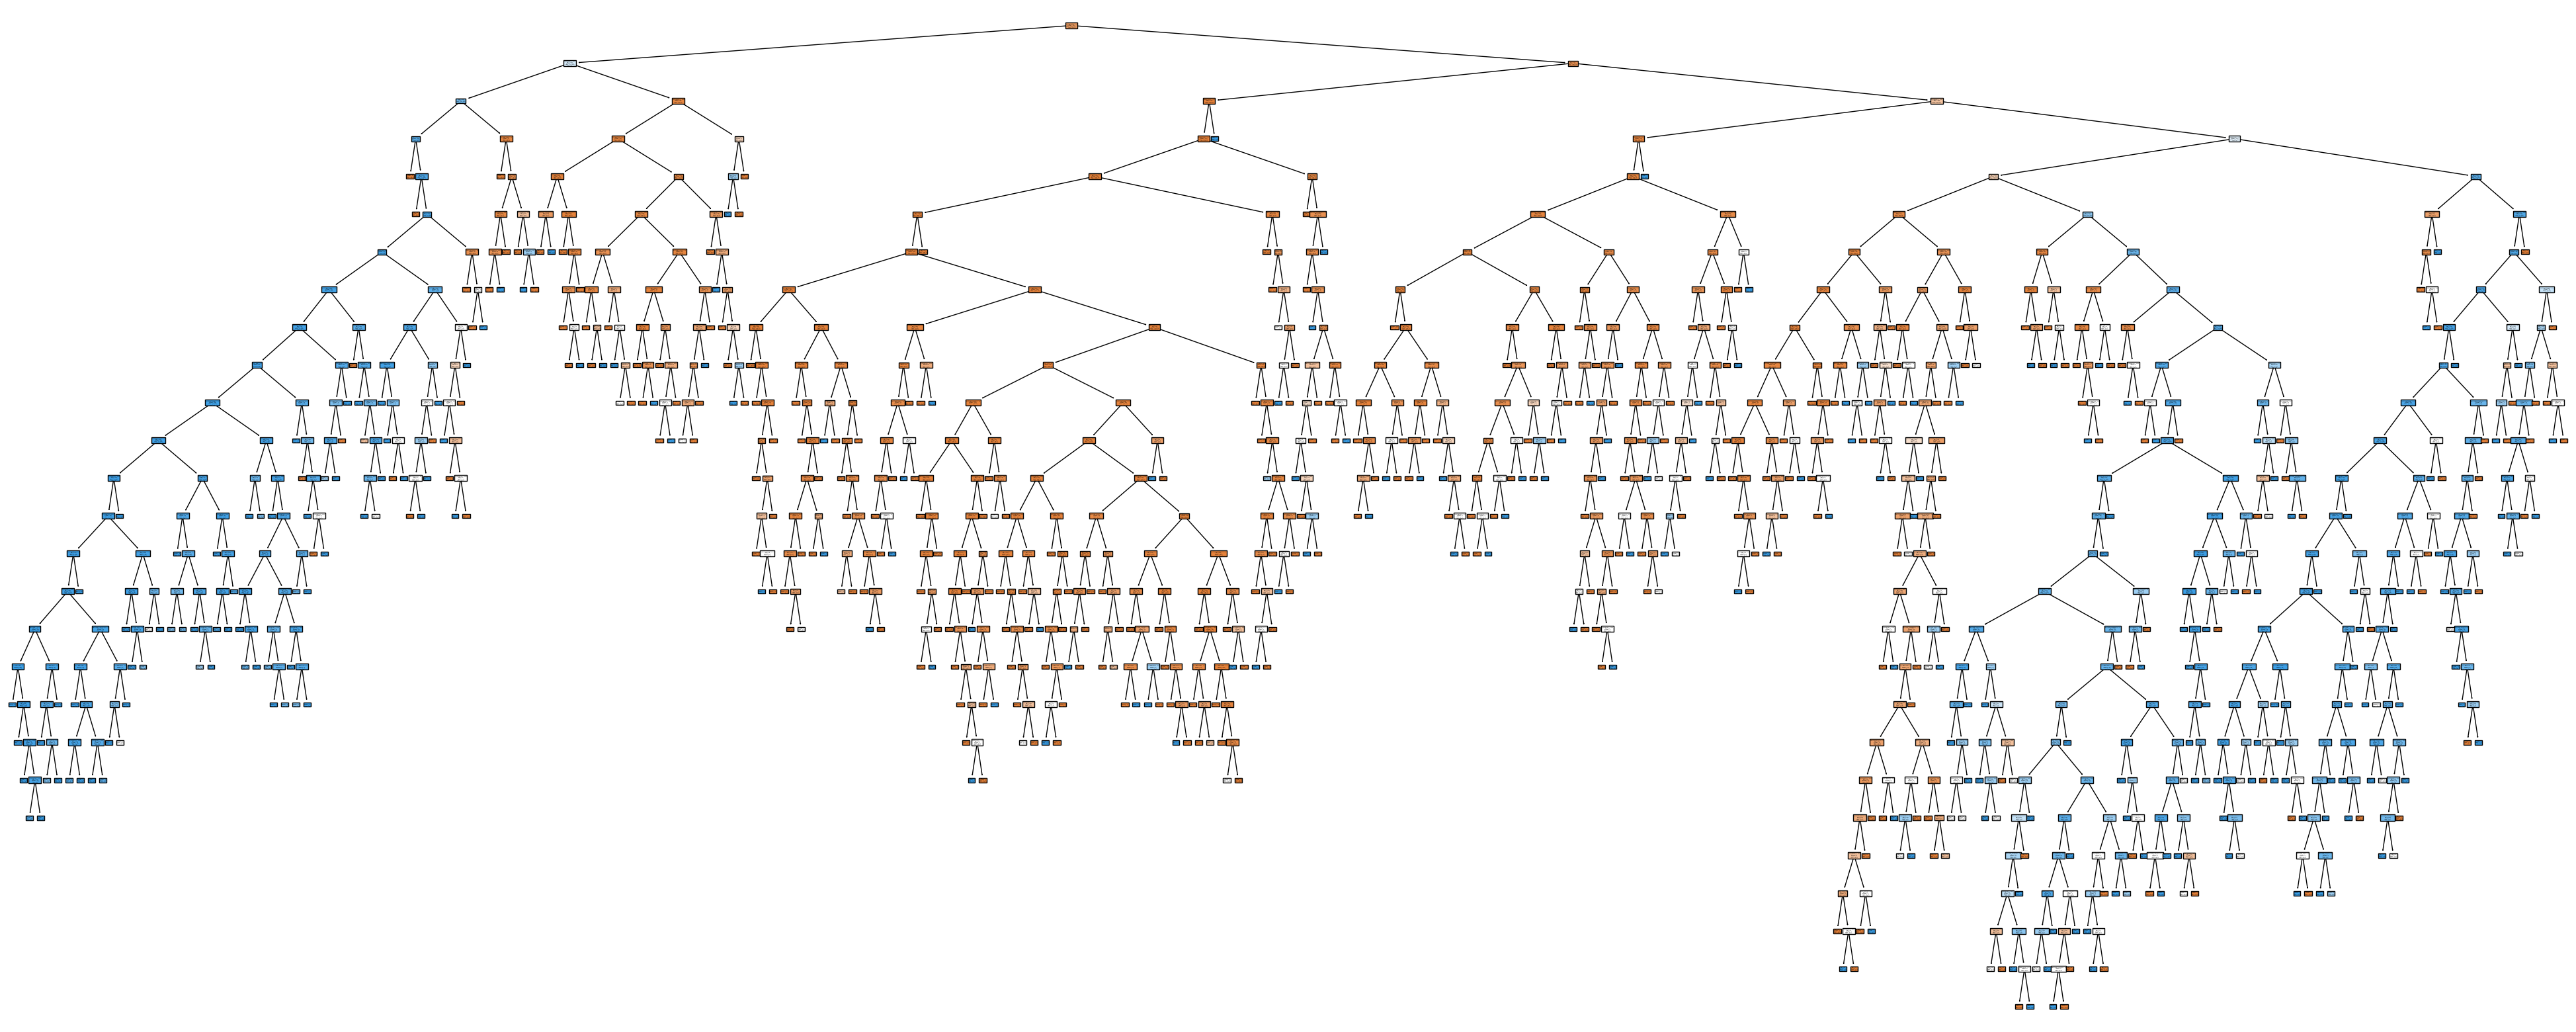

In [69]:
plt.figure(figsize=(50,20))
plot_tree(tree2,feature_names=X_1.columns,class_names={0:'stayed', 1:'left'}, filled=True)
plt.show()

## Hyperparameter Tuning Round 2

In [70]:
tree2 = DecisionTreeClassifier(random_state=42)

In [71]:
tree2_grid = GridSearchCV(estimator=tree2,
                          param_grid=tree_paras,
                          scoring=score,
                          refit='roc_auc',
                          cv=5,
                          n_jobs=-1,
                          verbose=1)

In [72]:
%%time
tree2_grid.fit(X_train_1,y_train_1)

Fitting 5 folds for each of 198 candidates, totalling 990 fits
CPU times: user 757 ms, sys: 59.2 ms, total: 817 ms
Wall time: 9.9 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                       None],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='roc_auc',
             scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                      'roc_auc'],
             verbose=1)

In [73]:
tree2_grid.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, random_state=42)

In [74]:
tree2_grid.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}

In [75]:
tree2_grid.best_score_*100

96.37804121937984

In [104]:
optimised_tree2 = DecisionTreeClassifier(max_depth= 6, min_samples_leaf= 10)

optimised_tree2.fit(X_train_1,y_train_1)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)

In [105]:
optimised_tree2_pred = optimised_tree2.predict(X_test_1)

In [78]:
print(make_results(trained_model=True,model_name="Tuned Decision Tree",test_data=y_test,model_prediction=optimal_tree_pred))
print('\n')
print(make_results(trained_model=True,model_name="Tuned Decision Tree Round 2",model_prediction=optimised_tree2_pred,test_data=y_test_1))

            Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Tuned Decision Tree     98.12   91.86      96.83  94.28    95.62


                    Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Tuned Decision Tree Round 2     96.48    89.2      89.84  89.52    93.58


Again Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good. and notice how this tuned tree performs better than the normal tree in terms of the `Auc` scores

Now Lets display the Tree

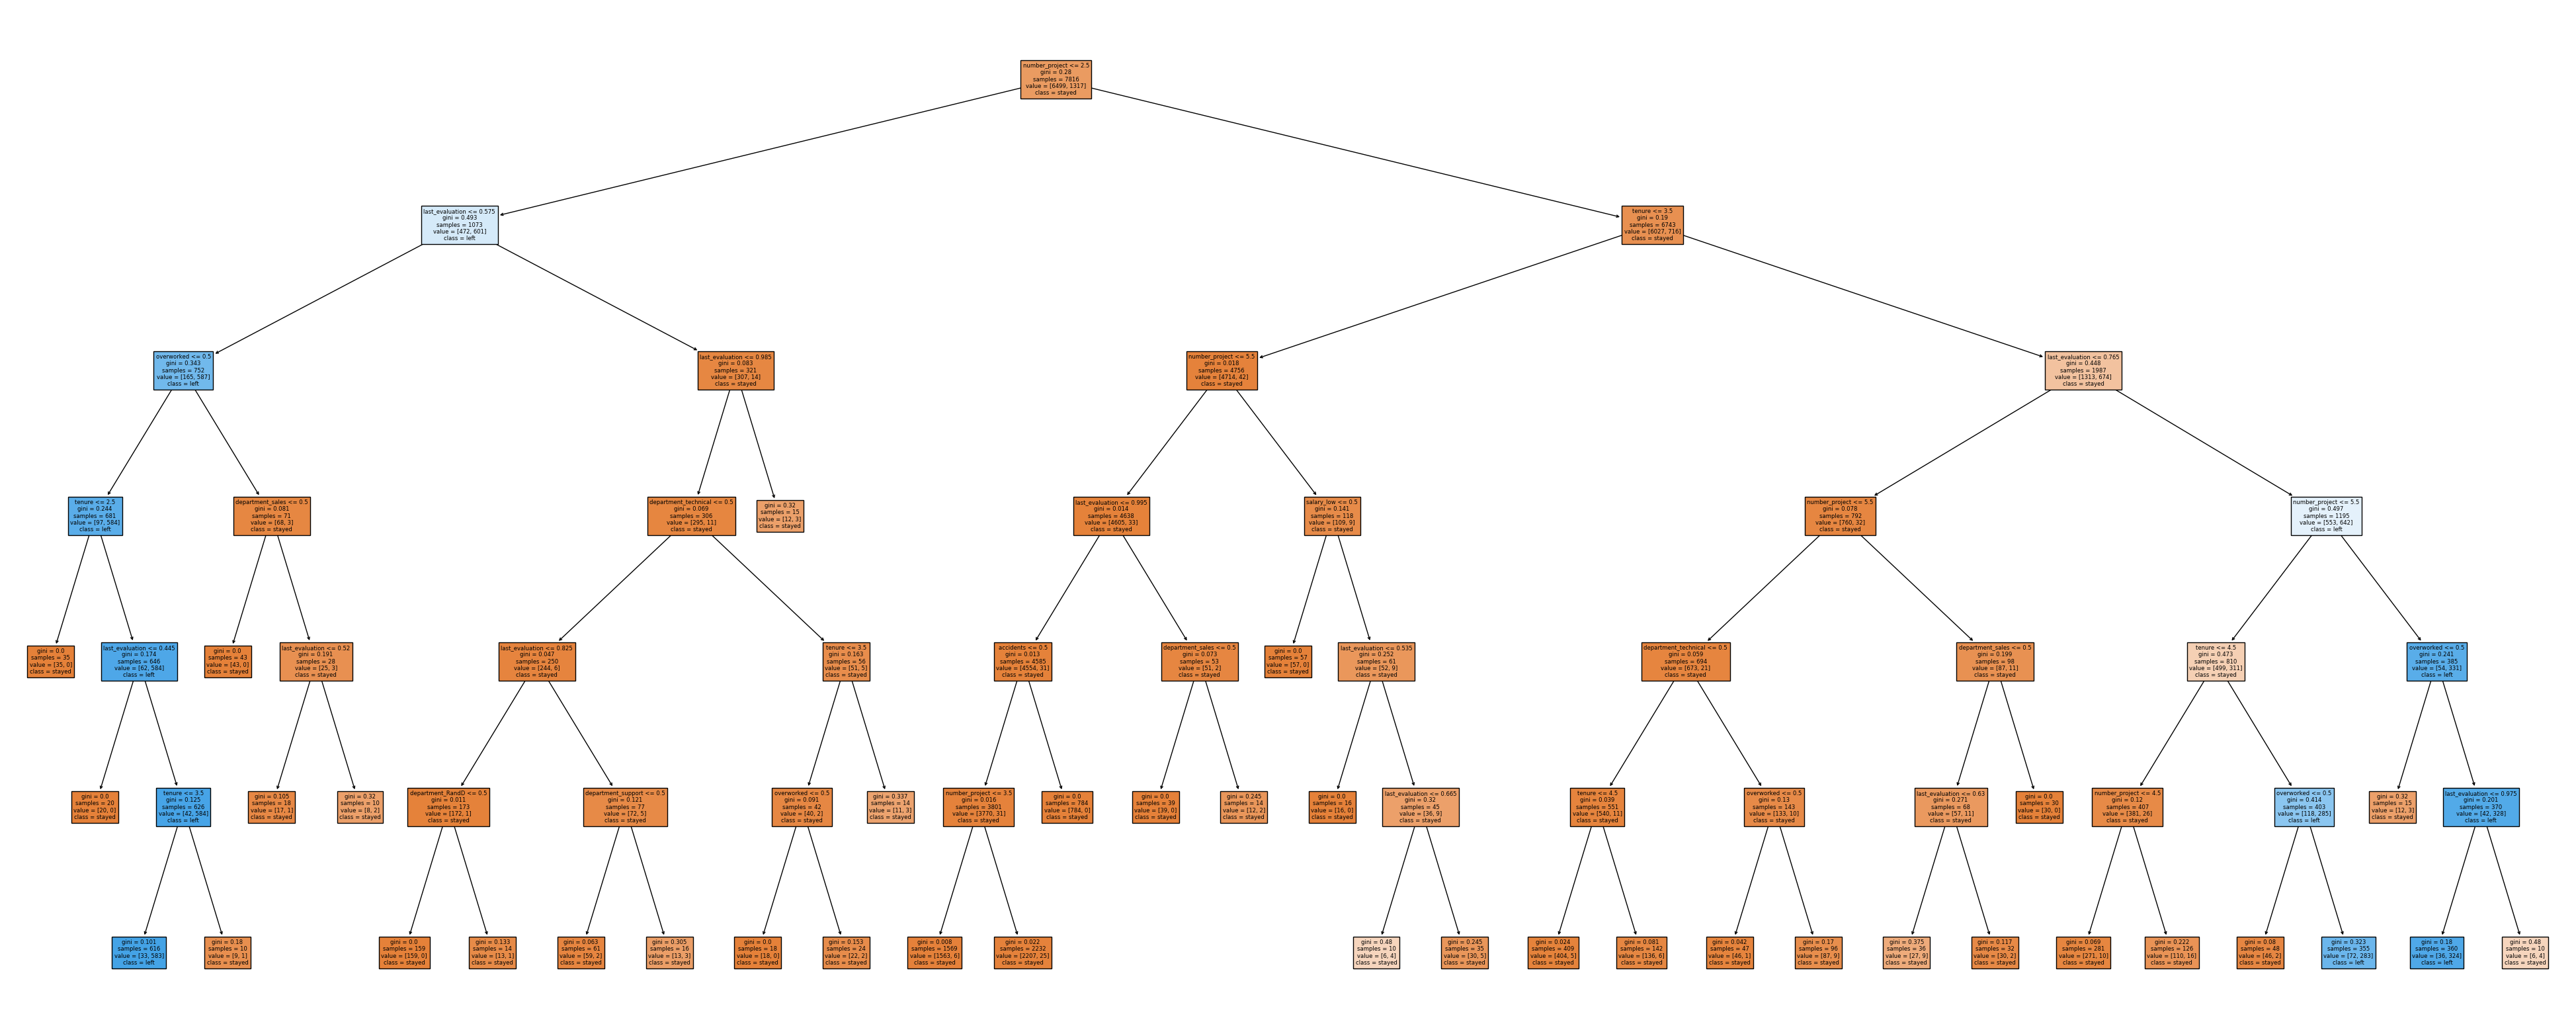

In [79]:
plt.figure(figsize=(50,20))
plot_tree(optimised_tree2,feature_names=X_1.columns,class_names={0:'stayed', 1:'left'}, filled=True)
plt.show()

## Random Forest Round 2

In [80]:
forest_2 = RandomForestClassifier(random_state=42)
forest_grid_2 = GridSearchCV(estimator=forest_2,
                           param_grid=forest_para,
                           scoring=score,
                           cv=5,
                           refit='roc_auc',
                           n_jobs=-1,
                           verbose=1)

In [81]:
%%time
forest_grid_2.fit(X_train_1,y_train_1)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
CPU times: user 16 s, sys: 1.91 s, total: 17.9 s
Wall time: 10min 7s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, None],
                         'max_features': ['sqrt'],
                         'max_samples': [0.5, 0.7, 0.8, None],
                         'min_samples_leaf': [1, 2, 3, 4, None],
                         'min_samples_split': [2, 3, 4, 5, None],
                         'n_estimators': [50, 70, 100, None]},
             refit='roc_auc',
             scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                      'roc_auc'],
             verbose=1)

In [82]:
forest_grid_2.best_estimator_

RandomForestClassifier(max_depth=10, max_samples=0.8, min_samples_leaf=2,
                       random_state=42)

In [83]:
forest_grid_2.best_score_

0.9710122235984631

In [84]:
forest_grid_2.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [85]:
optimal_tree_forest_2 = RandomForestClassifier(max_depth= 10,
 max_features= 'sqrt',
 max_samples= 0.8,
 min_samples_leaf= 2,
 min_samples_split= 2,
 n_estimators= 100,
 random_state=42)

In [86]:
optimal_tree_forest_2.fit(X_train_1,y_train_1)

RandomForestClassifier(max_depth=10, max_samples=0.8, min_samples_leaf=2,
                       random_state=42)

In [87]:
optimal_tree_forest_2_pred = optimal_tree_forest_2.predict(X_test_1)

In [88]:
print(make_results(trained_model=True,model_name="Optimal Random Forest",model_prediction=optimal_tree_forest_pred,test_data=y_test))
print('\n')
print(make_results(trained_model=True,model_name="Optimal Random Forest Round 2",model_prediction=optimal_tree_forest_2_pred,test_data=y_test_1))

              Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Optimal Random Forest     98.21   90.44      98.84  94.45    95.11


                      Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Optimal Random Forest Round 2     96.66   87.79      92.02  89.86    93.12


Again, the scores dropped slightly, but the random forest performs better than the decision tree if using AUC as the deciding metric. 

## Gradient Boosting Round 2

In [89]:
boost_2 = XGBClassifier(objective='binary:logistic',random_state=42)

In [90]:
# Create a GridSearchCV object for hyperparameter tuning of XGBoost model
boost_grid_2 = GridSearchCV(
    estimator=boost_2,  # 'boost' is assumed to be the XGBoost classifier object
    param_grid=gradient_parameters,  # Grid of parameters to search over
    scoring=score,  # Scoring metric for evaluation
    cv=5,  # Number of folds for cross-validation
    refit='roc_auc',  # Refit the best model with ROC AUC score
    n_jobs=-1,  # Use all available CPU cores for parallel computation
    verbose=1  # Verbosity level: 2 for detailed output
)

In [91]:
%%time
boost_grid_2.fit(X_train_1,y_train_1)

Fitting 5 folds for each of 1134 candidates, totalling 5670 fits
CPU times: user 20.7 s, sys: 2.7 s, total: 23.4 s
Wall time: 12min 28s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7],
                         'learning_rate': [0.5, 0.6, 0.7],
                         'max_depth': [8, 10, 20, 30, 40, 50, None],
                         'min_child_weight': [3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.6, 0.7]},
             refit='roc_auc',
             scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                      'roc_auc'],
             verbose=1)

In [92]:
boost_grid_2.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [93]:
boost_grid_2.best_score_

0.9665400427784373

In [94]:
boost_grid_2.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.5,
 'max_depth': 20,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.6}

In [95]:
optimal_boost_forest_2 = XGBClassifier(
random_state=42,
colsample_bytree= 0.6,
learning_rate= 0.5,
max_depth= 8,
min_child_weight= 5,
n_estimators= 100,
subsample= 0.5)

In [96]:
optimal_boost_forest_2.fit(X_train_1,y_train_1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [97]:
optimal_boost_forest_2_pred = optimal_boost_forest_2.predict(X_test_1)

In [98]:
print(make_results(trained_model=True,model_name="Optimal Gradient Boost Forest",model_prediction=optimal_boost_forest_pred,test_data=y_test))
print('\n')
print(make_results(trained_model=True,model_name="Optimal Gradient Boost Forest Round 2",model_prediction=optimal_boost_forest_2_pred,test_data=y_test_1))

                      Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Optimal Gradient Boost Forest     97.97   91.33      96.45  93.82    95.32


                              Model Name  Accuracy  Recall  Precision     F1  \
0  Optimal Gradient Boost Forest Round 2      96.3   87.79      90.02  88.89   

   Roc_Auc  
0    92.91  


Again, the scores dropped slightly, but the gradient boost still performs better if using AUC as the deciding metric. 

# Results and Evaluation

In [99]:
results_scores = pd.concat([make_results(trained_model=True,model_name="Round 1 Tree",test_data=y_test,model_prediction=tree1_pred),
                     make_results(model_name="Round 1 Tuned Tree",model_object=tree1_grid),
                     make_results(model_name="Round 1 Forest",model_object=forest_grid),
                     make_results(model_name="Round 1 XGBoost",model_object=boost_grid),
                     make_results(trained_model=True,model_name="Round 2 Tree",test_data=y_test_1,model_prediction=tree2_pred),
                     make_results(model_name="Round 2 Tuned Tree",model_object=tree2_grid),
                     make_results(model_name="Round 2 Forest",model_object=forest_grid_2),
                     make_results(model_name="Round 2 XGBoost",model_object=boost_grid_2)],ignore_index=True)

results_scores

Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0        Round 1 Tree     97.17   91.68      91.52  91.60    94.98
1  Round 1 Tuned Tree     98.31   95.83      98.08  96.91    96.19
2      Round 1 Forest     98.23   95.36      98.30  96.75    98.26
3     Round 1 XGBoost     97.94   95.31      97.26  96.24    97.78
4        Round 2 Tree     94.18   84.07      81.90  82.97    90.15
5  Round 2 Tuned Tree     96.85   94.02      94.68  94.34    95.48
6      Round 2 Forest     96.83   93.79      94.79  94.28    96.93
7     Round 2 XGBoost     96.49   93.38      94.03  93.70    96.31

The Scores of the first 4 Models are quite different from the Round 2 Models:-

- The `Accuracy` Scores of the first four Models are quite Consistant except the `Normal Single Tree`
- The `Recall` Scores of the first four are also consistant except the `Normal Single Tree`
- The `Precision` Scores of the first four are also consistant except the `Normal Single Tree`
- The `F1` scores of the first four models are also quite consistant except `Normal Single Tree`
- The `Roc_Auc` Scores of the first four are also consistant except the `Normal Single Tree` and `Random Forest`

Whereas when we look at the scores of the `Round 2` Models we see that:-

- The `Accuracy` Scores of the four Models have changed from that of the earlier models due to lesser features in training data
- The `Recall` Scores of the four models have droped 
- The `Precision` Scores of the four have droped to a noticable number
- The `F1` Scores of the four have droped to a noticable number
- The `Roc_Auc` Scores of the four are also consistant except the `Normal Single Tree`

i have observed that the `Normal Single Tree` 

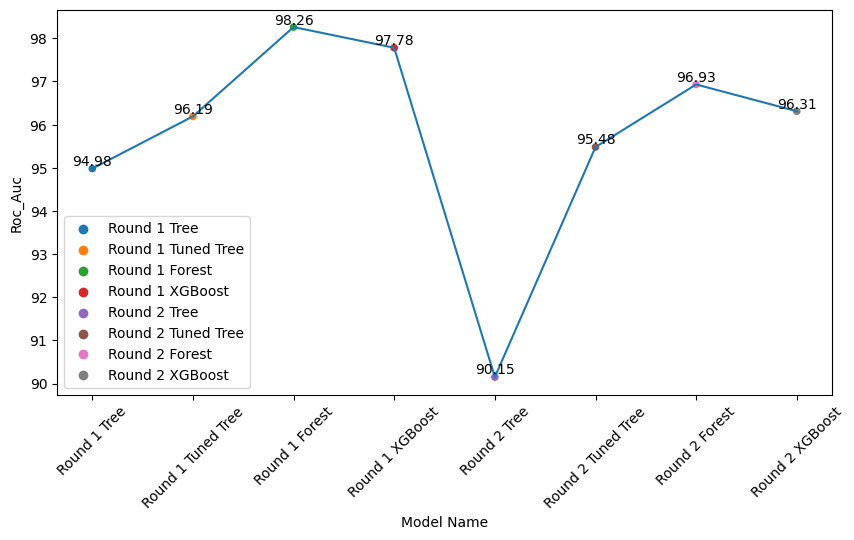

In [100]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=results_scores['Model Name'],y=results_scores['Roc_Auc'],hue=results_scores['Model Name'])
sns.lineplot(x=results_scores['Model Name'],y=results_scores['Roc_Auc'])
for i in range(len(results_scores)):
    plt.text(results_scores['Model Name'][i], results_scores['Roc_Auc'][i], str(round(results_scores['Roc_Auc'][i], 2)), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.show()

**Choosing the Round Based on Roc_Auc Score:** If we are considering only the Roc_Auc score, then the models from the first round have higher scores. However, if we take into account the concern of data leakage and overfitting, the second round models might be more robust and generalize better to unseen data, despite having slightly lower Roc_Auc scores.

**Choosing the Model Based on Roc_Auc Score:** In the first round, the model with the highest Roc_Auc score is the ‘XGBoost Optimal Forest’ with a score of 98.26. In the second round, the model with the highest Roc_Auc score is the ‘Optimal Random Forest Round 2’ with a score of 96.93.

But lets not be hasty and analyse further

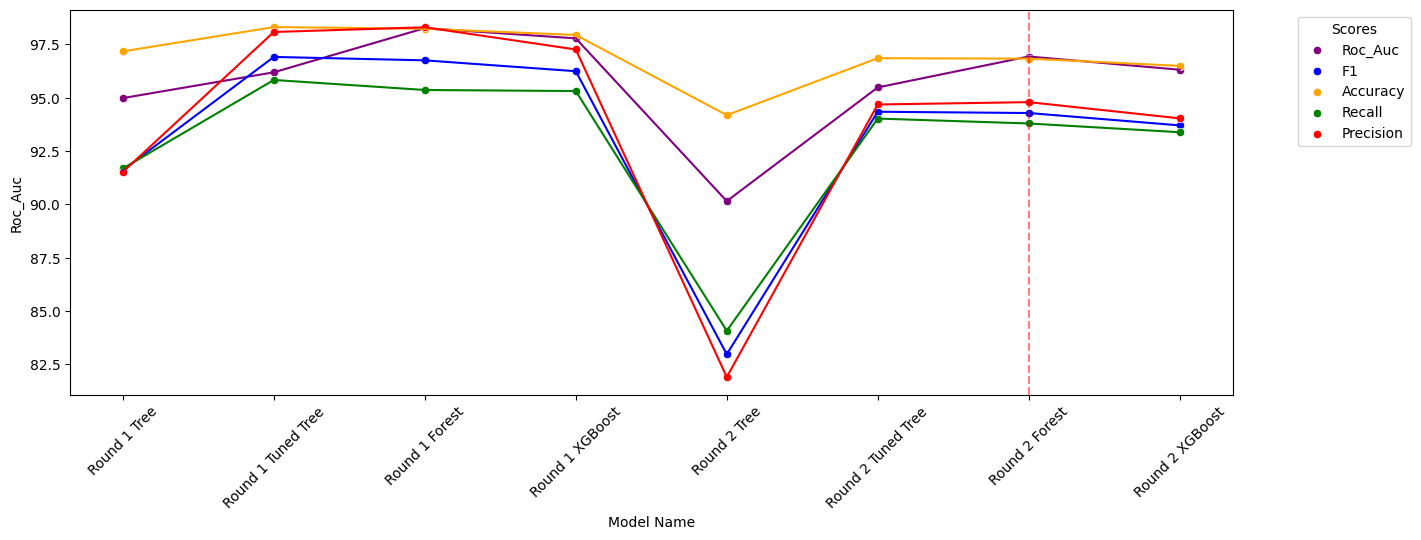

In [101]:
plt.figure(figsize=(15, 5))

# plot Roc_Auc Score
sns.scatterplot(x=results_scores['Model Name'],y=results_scores['Roc_Auc'],label='Roc_Auc',color='purple')
sns.lineplot(x=results_scores['Model Name'],y=results_scores['Roc_Auc'],color='purple')

# Plot F1 score
sns.scatterplot(data=results_scores, x='Model Name', y='F1', label='F1', color='blue')
sns.lineplot(data=results_scores, x='Model Name', y='F1', color='blue')

# Plot Accuracy
sns.scatterplot(data=results_scores, x='Model Name', y='Accuracy', label='Accuracy', color='orange')
sns.lineplot(data=results_scores, x='Model Name', y='Accuracy', color='orange')

# Plot Recall
sns.scatterplot(data=results_scores, x='Model Name', y='Recall', label='Recall', color='green')
sns.lineplot(data=results_scores, x='Model Name', y='Recall', color='green')

# Plot Precision
sns.scatterplot(data=results_scores, x='Model Name', y='Precision', label='Precision', color='red')
sns.lineplot(data=results_scores, x='Model Name', y='Precision', color='red')

plt.xticks(rotation=45)
plt.axvline(x='Round 2 Forest', color='red', linestyle='--', alpha=0.5)
plt.legend(title='Scores', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Choosing the Round Based on All Scores:** If we consider all the scores ( `accuracy`, `recall`, `precision`, `F1`, and `Roc_Auc` ), the first round models have higher scores. However, as i mentioned earlier, if we are concerned about overfitting, the second round models might be a better choice despite having slightly lower scores.

**Choosing the Model Based on All Scores:** In the first round, the `Tuned Decision Tree` model has high scores across all metrics. In the second round, again the ‘ `Optimal Random Forest Round 2` ’ model has relatively high scores across all metrics.

Now lets Take a Look at The `Confusion Matrix` Score's of the Initial 4 Models of Round 1

In [102]:
results = confusion_matrix(
DataFrame=True,
model=tree1,
model_2=optimal_tree,
model_3=optimal_tree_forest,
model_4=optimal_boost_forest,
test_data=x_test,
x_tr=x_train,
y_tr=y_train,
actual_data=y_test
)
results

Model Name  True Negatives  True Positives  False Negatives  \
0    model 0           81.71           15.46             1.40   
1    model 1           82.63           15.49             1.37   
2    model 2           82.96           15.25             1.61   
3    model 3           82.57           15.40             1.46   

   False Positives  True Negatives Training  True Positives Training  \
0             1.43                    83.15                    16.85   
1             0.51                    82.46                    15.55   
2             0.18                    83.00                    15.42   
3             0.57                    83.01                    16.08   

   False Negatives Training  False Positives Training  
0                      0.00                      0.00  
1                      1.31                      0.69  
2                      1.43                      0.15  
3                      0.77                      0.14

Now lets Take a Look at The `Confusion Matrix` Score's of the 4 Models of Round 2

In [109]:
results_2 = confusion_matrix(
DataFrame=True,
model=tree2,
model_2=optimised_tree2,
model_3=optimal_tree_forest_2,
model_4=optimal_boost_forest_2,
test_data=X_test_1,
x_tr=X_train_1,
y_tr=y_train_1,
actual_data=y_test_1
)
results_2

Model Name  True Negatives  True Positives  False Negatives  \
0    model 0           80.01           14.17             2.69   
1    model 1           81.44           15.04             1.82   
2    model 2           81.86           14.80             2.06   
3    model 3           81.50           14.80             2.06   

   False Positives  True Negatives Training  True Positives Training  \
0             3.13                    82.88                    16.34   
1             1.70                    81.35                    15.23   
2             1.28                    81.99                    15.23   
3             1.64                    81.87                    15.30   

   False Negatives Training  False Positives Training  
0                      0.51                      0.27  
1                      1.62                      1.80  
2                      1.62                      1.16  
3                      1.55                      1.28

Plotting the `Confusion Matrix` of the Round 1 Models

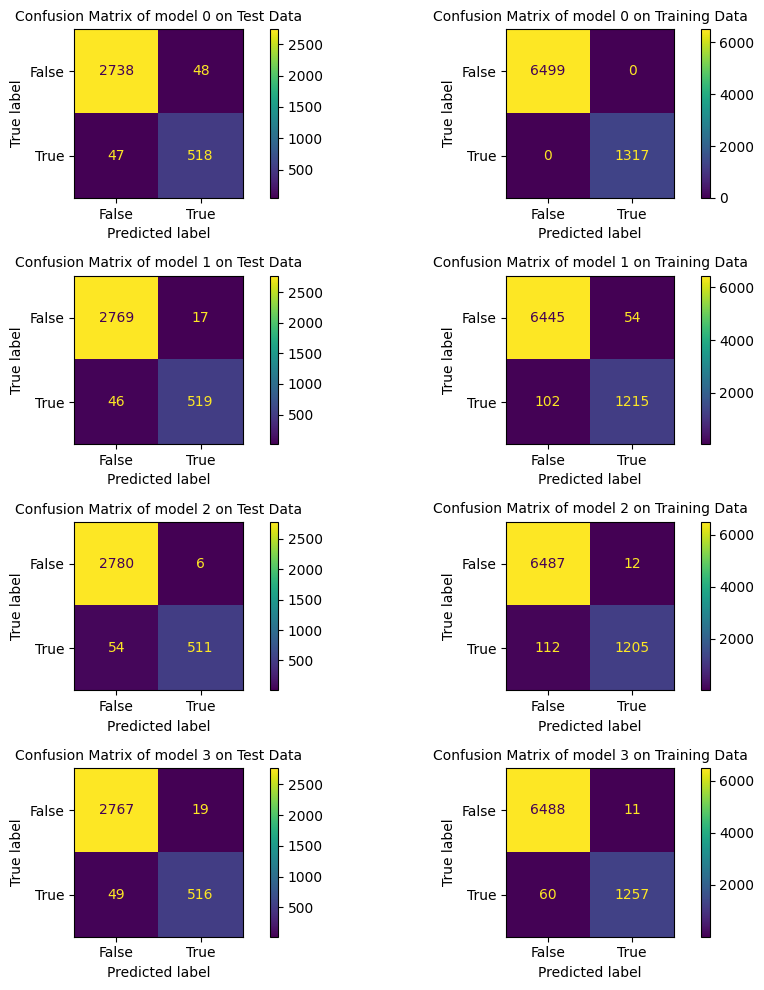

In [110]:
confusion_matrix(
multiple=True,
model=tree1,
model_2=optimal_tree,
model_3=optimal_tree_forest,
model_4=optimal_boost_forest,
test_data=x_test,
x_tr=x_train,
y_tr=y_train,
actual_data=y_test,
w=10,
l=10,
f=10)

**Choosing Based On this round**: based on the data and the confusion metrix each model performed exceptionally on testing data and training data so if we consider this data and round, we can say that `Model 3` which is `XGBoost` has the best performance based on the balance of the prediction But considering the risk of `Overfitting` of the Initial Models we cannot choose from among them

Plotting the `Confusion Matrix` of the Round 2 Models

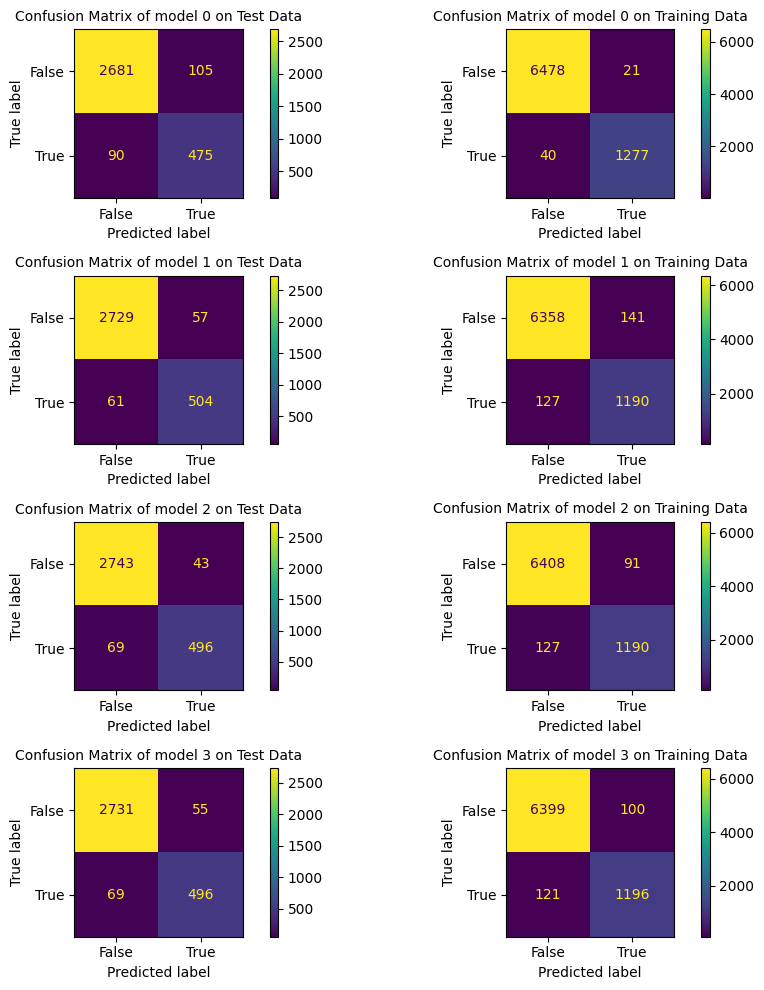

In [111]:
confusion_matrix(
multiple=True,
model=tree2,
model_2=optimised_tree2,
model_3=optimal_tree_forest_2,
model_4=optimal_boost_forest_2,
test_data=X_test_1,
x_tr=X_train_1,
y_tr=y_train_1,
actual_data=y_test_1,
w=10,
l=10,
f=10)

**Choosing Based on this Round** 

In this round we can see that the models have performed in fluctuations as compared to the round 1 models so this clearly states that the earlier models were `Overfitted` 

The `Round 2` Models showed fluctuations in their predictions which tells us that these models are more `Robust` and can generalise more efficiently on the unseen dat

Now in this round there are 2 models that are similar in prediction the `Random Forest` and `XBGoost Model` they both have a similar perdictions.

We can choose the `Random Forest` but i think we should choose the `XGBoost Model` as the model put a huge emphasis on the errors made by the single decision trees

so we choose `XGBoost Model` as our Champion Model, now we will see that on what features did this model put emphasis on while training

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

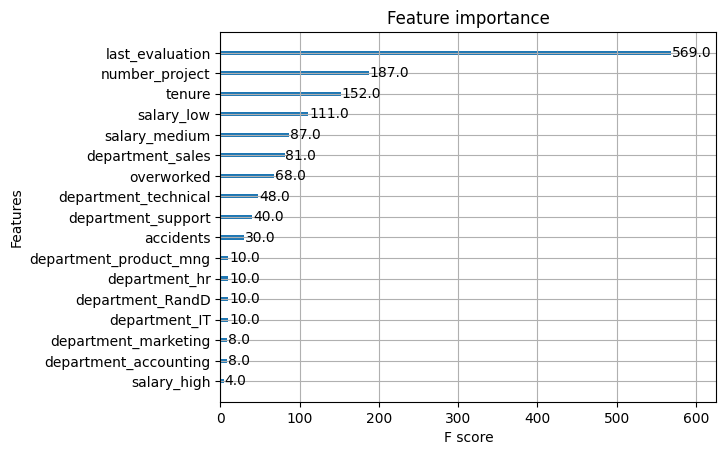

In [112]:
plot_importance(optimal_boost_forest_2)

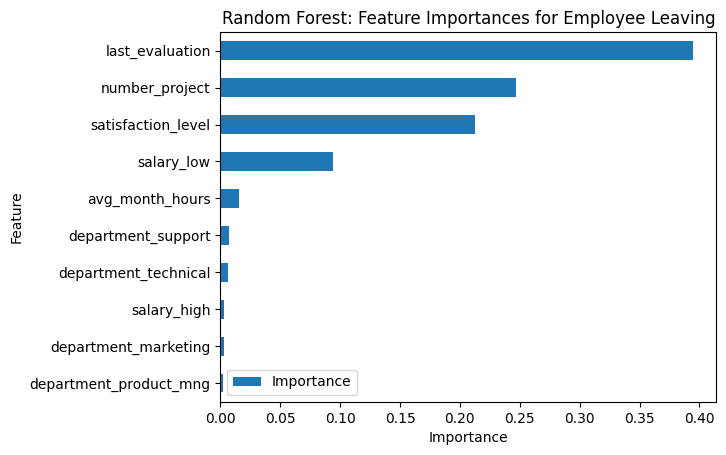

In [113]:
# Get feature importances
feat_impt = forest_grid_2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(forest_grid_2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

In [114]:
make_results(trained_model=True,model_name='Random Forest',model_prediction=optimal_tree_forest_2_pred,test_data=y_test_1)

Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0  Random Forest     96.66   87.79      92.02  89.86    93.12

In [115]:
make_results(trained_model=True,model_name='XGBoost',model_prediction=optimal_boost_forest_2_pred,test_data=y_test_1)

Model Name  Accuracy  Recall  Precision     F1  Roc_Auc
0    XGBoost      96.3   87.79      90.02  88.89    92.91

Both the models put emphasis on similar features for predictions and have almost the same scores so we can say that we can choose the `XGBoost` model for the predictions on the unseen data because `XGBoost` put a huge emphasis on the errors made by the ensamble learners

**Tree-based Machine Learning**

After conducting feature engineering, the `XGBoost` tree model achieved AUC of 92.96%, precision of 90.51%, recall of 87.79%, f1-score of 89.13%, and accuracy of 96.39%, on the test set. The `XGBoost` modestly outperformed the `Single decision tree` model and `Tunes Decision Tree` Model. 